In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)

## Data Loading

In [3]:
def process_folder(input_folder, output_file):
    averaged_data = []

    # Iterate over all CSV files in the folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(input_folder, file_name)
            df = pd.read_csv(file_path)
            
            # Calculate the average for each column (ignoring NaN values)
            avg_row = df.mean(axis=0)
            averaged_data.append(avg_row)

    # Combine all averaged rows into a single DataFrame
    averaged_df = pd.DataFrame(averaged_data)
    
    # Save the DataFrame to a CSV file
    averaged_df.to_csv(output_file, index=False)
    print(f"Processed {len(averaged_data)} files and saved to {output_file}")

process_folder("dataset/dataset/sepsis", "sepsis.csv")
process_folder("dataset/dataset/no_sepsis", "no_sepsis.csv")


Processed 1000 files and saved to sepsis.csv
Processed 1000 files and saved to no_sepsis.csv


In [4]:
# Load the sepsis and no_sepsis datasets
sepsis_data = pd.read_csv("sepsis.csv")
no_sepsis_data = pd.read_csv("no_sepsis.csv")

# Add target column
sepsis_data['sepsis_icd'] = 1
no_sepsis_data['sepsis_icd'] = 0

# Combine the datasets
combined_data = pd.concat([sepsis_data, no_sepsis_data], ignore_index=True)

# Sample 250 patients from each category
sepsis_sample = sepsis_data.sample(n=250, random_state=42)
no_sepsis_sample = no_sepsis_data.sample(n=250, random_state=42)

# Combine the sampled data
selected_combined_data = pd.concat([sepsis_sample, no_sepsis_sample], ignore_index=True)

In [5]:
combined_data.head()

,heart_rate,bp_systolic,bp_diastolic,map,resp,temp,spo2,fio2,wbc,bun,...,bicarbonate,hemoglobin,hematocrit,potassium,chloride,gcs,age,sirs,qsofa,sepsis_icd
0,76.500000,137.666667,47.250000,70.750000,15.791667,36.988426,95.208333,50.000000,12.888889,69.944444,...,23.833333,9.744444,29.094444,4.044444,97.055556,15.000000,58.59,0.083333,0.000000,1
1,84.173913,98.478261,53.826087,70.188409,18.260870,37.009662,99.304348,NaN,32.305000,34.000000,...,16.000000,10.450000,30.605000,4.480000,116.550000,7.956522,86.88,0.478261,0.478261,1
2,83.913043,107.434783,60.608696,72.260870,22.521739,35.903382,97.304348,41.304348,8.995652,19.347826,...,26.217391,12.778261,35.208696,3.465217,104.000000,10.652174,84.52,0.521739,0.652174,1
3,72.083333,177.208333,100.583333,97.625000,22.916667,36.417874,96.565217,47.142857,13.878261,31.652174,...,19.478261,16.830435,49.043478,4.782609,105.869565,14.782609,64.97,0.750000,0.000000,1
4,104.900000,107.000000,65.100000,79.066660,18.125000,37.466667,97.600000,NaN,10.062500,3.000000,...,24.000000,11.087500,31.812500,3.478947,105.000000,15.000000,42.71,0.047619,0.000000,1


In [6]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   heart_rate    2000 non-null   float64
 1   bp_systolic   2000 non-null   float64
 2   bp_diastolic  2000 non-null   float64
 3   map           1999 non-null   float64
 4   resp          2000 non-null   float64
 5   temp          2000 non-null   float64
 6   spo2          1998 non-null   float64
 7   fio2          509 non-null    float64
 8   wbc           2000 non-null   float64
 9   bun           2000 non-null   float64
 10  bilirubin     912 non-null    float64
 11  creatinine    2000 non-null   float64
 12  lactate       1193 non-null   float64
 13  platelets     1999 non-null   float64
 14  ph            1324 non-null   float64
 15  pco2          1266 non-null   float64
 16  po2           1267 non-null   float64
 17  bicarbonate   1997 non-null   float64
 18  hemoglobin    1994 non-null 

## Exploratory Data Analysis (EDA)

In [8]:
def plot_correlation_matrix(df, target=None):
    
    # Compute the correlation matrix
    corr_matrix = df.corr()

    # Plot the correlation matrix
    plt.figure(figsize=(16, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()

    # If a target column is specified, print sorted correlations
    if target:
        if target in corr_matrix.columns:
            target_corr = corr_matrix[target].sort_values(ascending=False)
            print(f"Correlations with {target} (sorted):")
            print(target_corr)
        else:
            print(f"Target column '{target}' not found in DataFrame.")



In [9]:
combined_data.head()

,heart_rate,bp_systolic,bp_diastolic,map,resp,temp,spo2,fio2,wbc,bun,...,bicarbonate,hemoglobin,hematocrit,potassium,chloride,gcs,age,sirs,qsofa,sepsis_icd
0,76.500000,137.666667,47.250000,70.750000,15.791667,36.988426,95.208333,50.000000,12.888889,69.944444,...,23.833333,9.744444,29.094444,4.044444,97.055556,15.000000,58.59,0.083333,0.000000,1
1,84.173913,98.478261,53.826087,70.188409,18.260870,37.009662,99.304348,NaN,32.305000,34.000000,...,16.000000,10.450000,30.605000,4.480000,116.550000,7.956522,86.88,0.478261,0.478261,1
2,83.913043,107.434783,60.608696,72.260870,22.521739,35.903382,97.304348,41.304348,8.995652,19.347826,...,26.217391,12.778261,35.208696,3.465217,104.000000,10.652174,84.52,0.521739,0.652174,1
3,72.083333,177.208333,100.583333,97.625000,22.916667,36.417874,96.565217,47.142857,13.878261,31.652174,...,19.478261,16.830435,49.043478,4.782609,105.869565,14.782609,64.97,0.750000,0.000000,1
4,104.900000,107.000000,65.100000,79.066660,18.125000,37.466667,97.600000,NaN,10.062500,3.000000,...,24.000000,11.087500,31.812500,3.478947,105.000000,15.000000,42.71,0.047619,0.000000,1


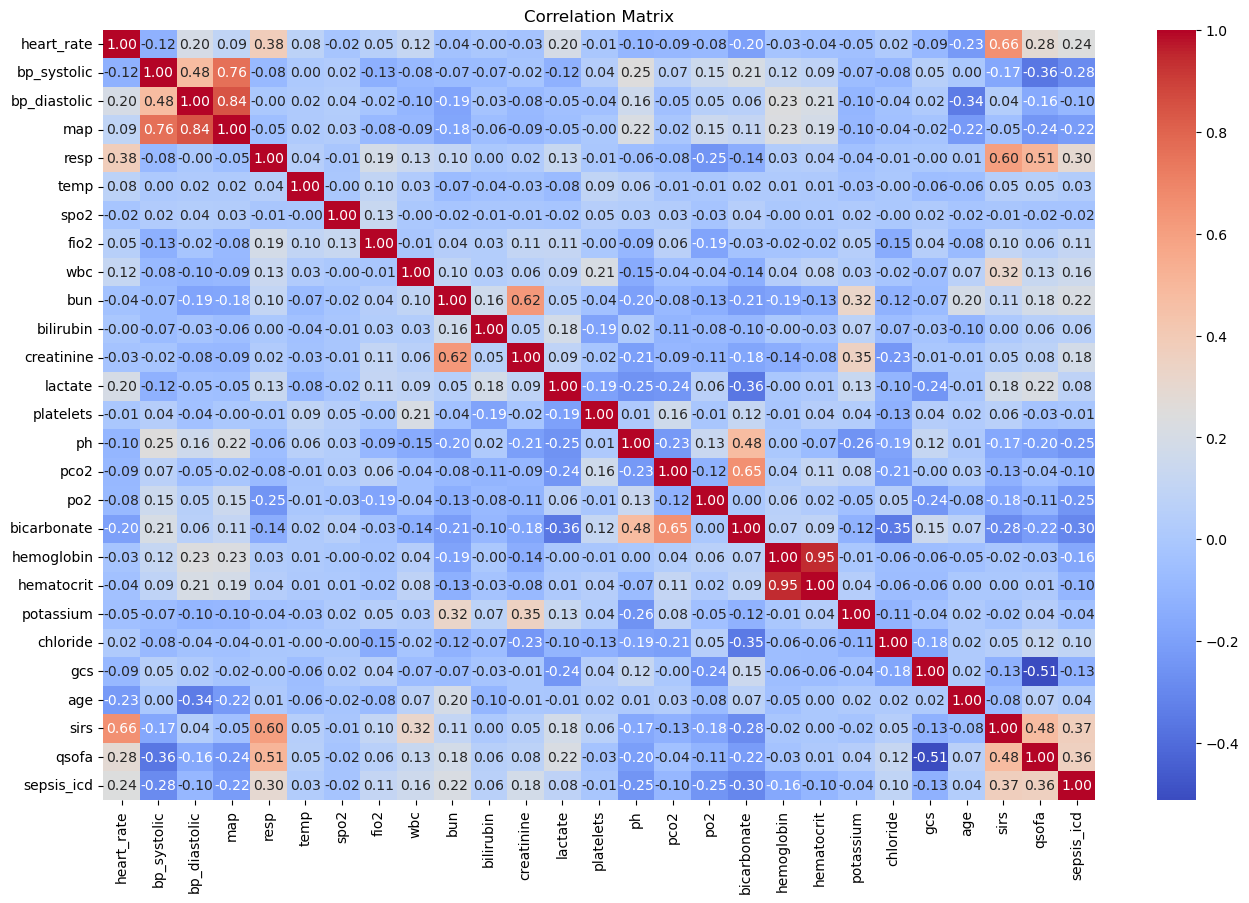

Correlations with sepsis_icd (sorted):
sepsis_icd      1.000000
sirs            0.370236
qsofa           0.356909
resp            0.296684
heart_rate      0.242056
bun             0.219593
creatinine      0.182809
wbc             0.159210
fio2            0.112576
chloride        0.095040
lactate         0.079219
bilirubin       0.058915
age             0.037694
temp            0.031400
platelets      -0.012726
spo2           -0.022616
potassium      -0.043345
bp_diastolic   -0.095611
pco2           -0.097021
hematocrit     -0.097992
gcs            -0.126053
hemoglobin     -0.163578
map            -0.218557
ph             -0.247863
po2            -0.249408
bp_systolic    -0.284987
bicarbonate    -0.301249
Name: sepsis_icd, dtype: float64


In [10]:
plot_correlation_matrix(combined_data, 'sepsis_icd')

In [11]:
def compare_distributions(dataset1, dataset2, feature, dataset1_label="Dataset 1", dataset2_label="Dataset 2"):
    if feature not in dataset1.columns or feature not in dataset2.columns:
        print(f"The feature '{feature}' must exist in both datasets.")
        return

    # Extract the feature from both datasets
    data1 = dataset1[feature]
    data2 = dataset2[feature]

    plt.figure(figsize=(10, 6))

    # Plot the distributions
    plt.hist(data1, bins=50, alpha=0.5, label=dataset1_label)
    plt.hist(data2, bins=50, alpha=0.5, label=dataset2_label)

    # Add labels and legend
    plt.title(f"Distribution Comparison for '{feature}'")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')

    plt.show()


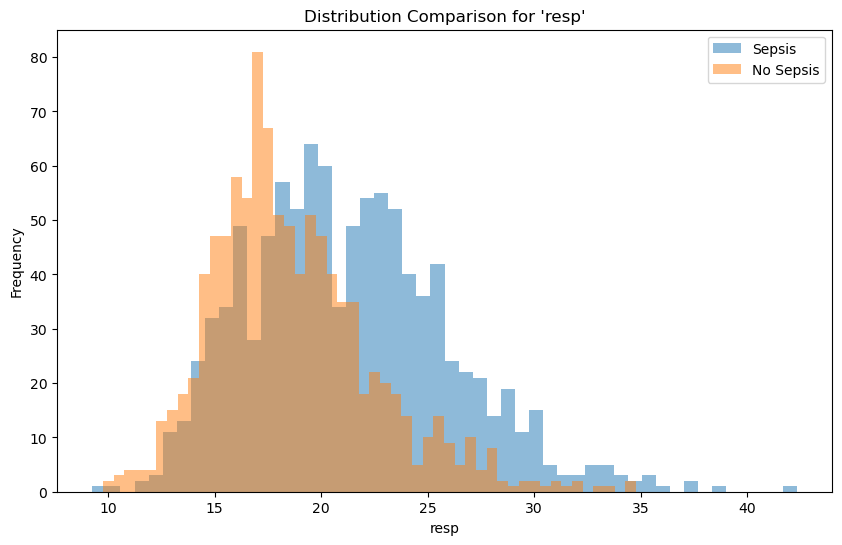

In [12]:
compare_distributions(sepsis_data, no_sepsis_data, 'resp', "Sepsis", "No Sepsis")

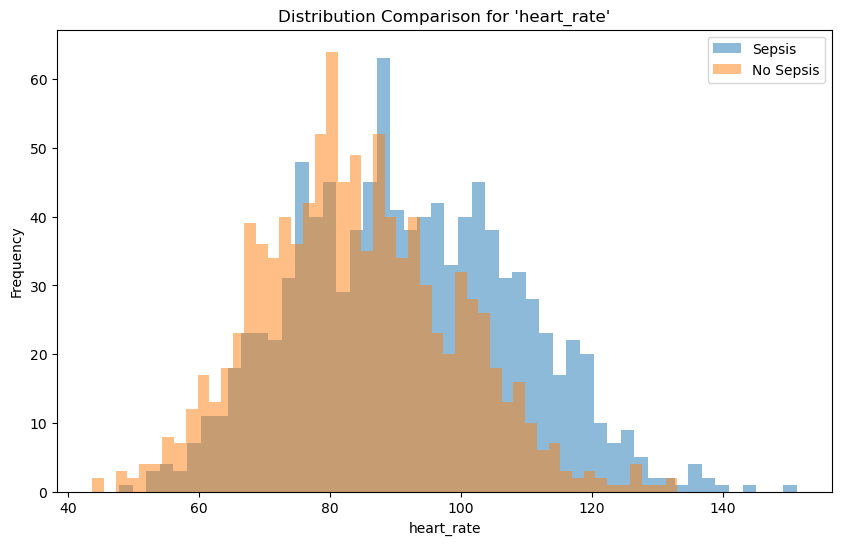

In [13]:
compare_distributions(sepsis_data, no_sepsis_data, 'heart_rate', "Sepsis", "No Sepsis")

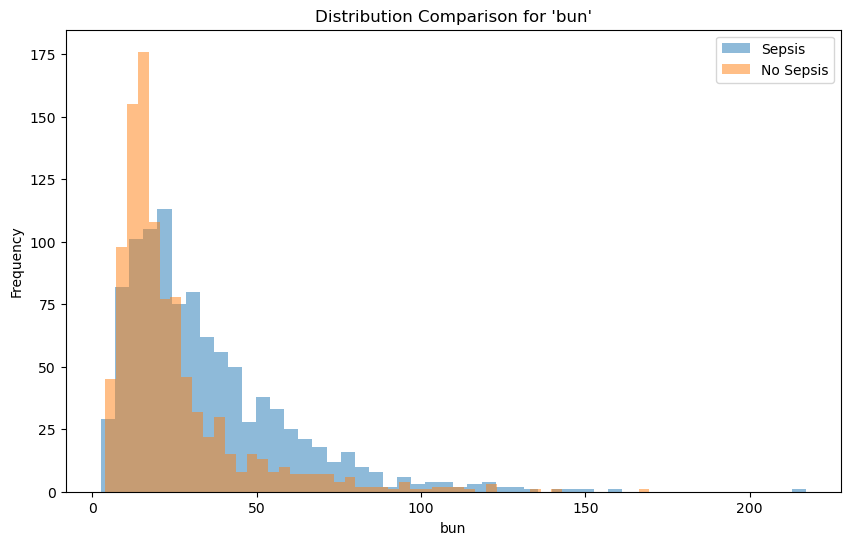

In [14]:
compare_distributions(sepsis_data, no_sepsis_data, 'bun', "Sepsis", "No Sepsis")

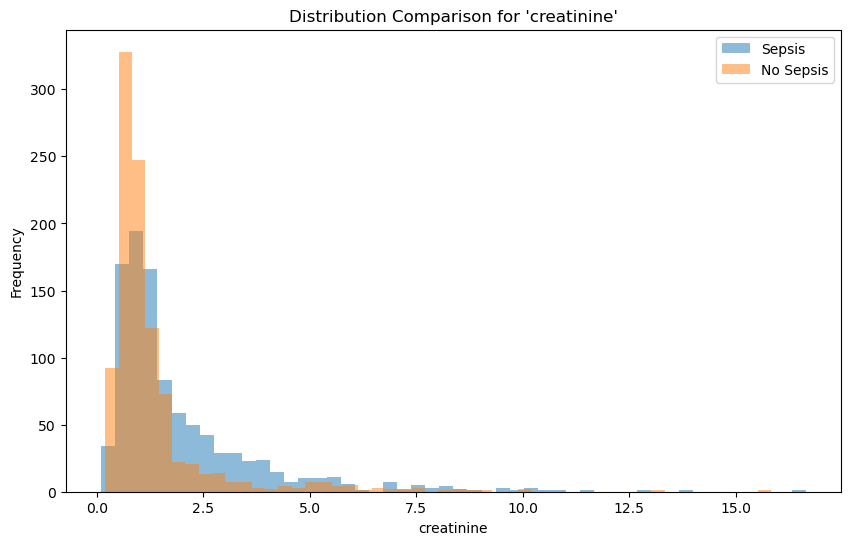

In [15]:
compare_distributions(sepsis_data, no_sepsis_data, 'creatinine', "Sepsis", "No Sepsis")

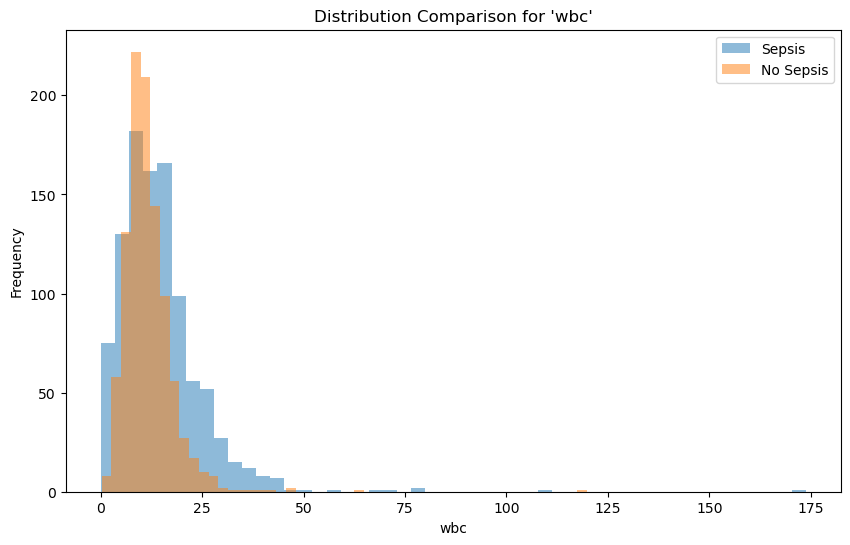

In [16]:
compare_distributions(sepsis_data, no_sepsis_data, 'wbc', "Sepsis", "No Sepsis")

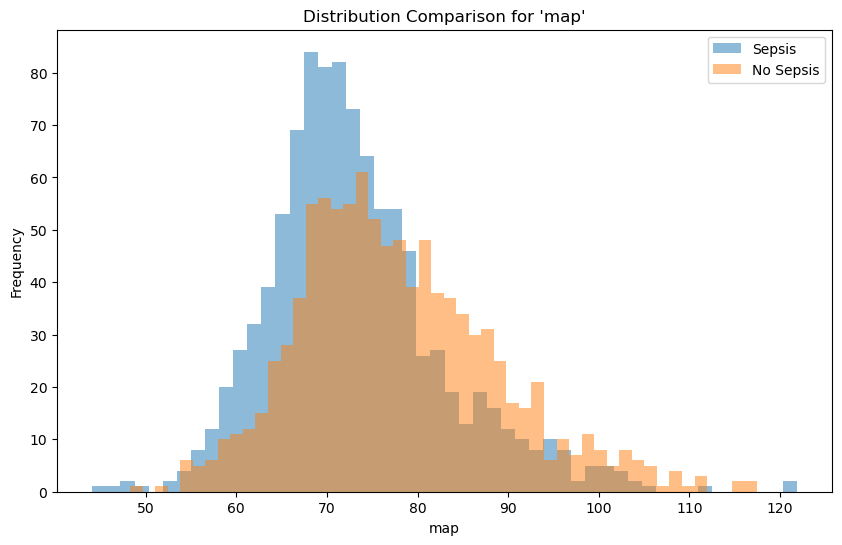

In [17]:
compare_distributions(sepsis_data, no_sepsis_data, 'map', "Sepsis", "No Sepsis")

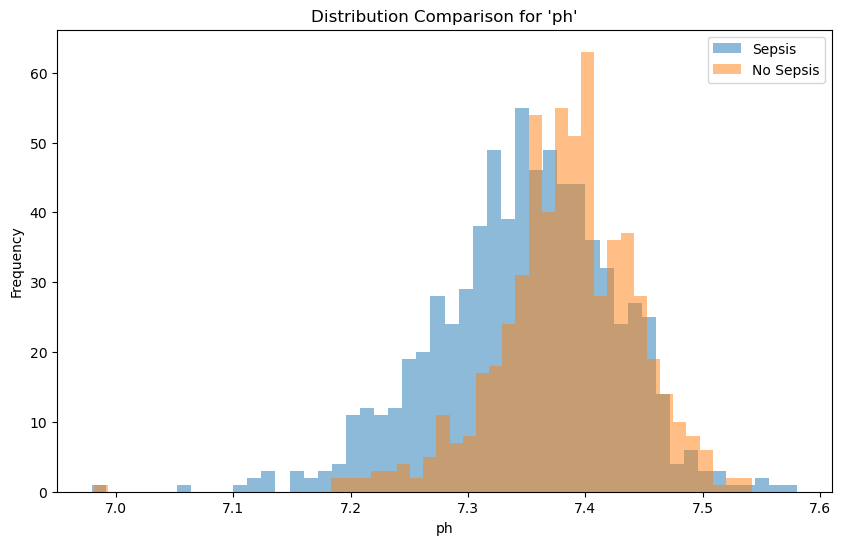

In [18]:
compare_distributions(sepsis_data, no_sepsis_data, 'ph', "Sepsis", "No Sepsis")

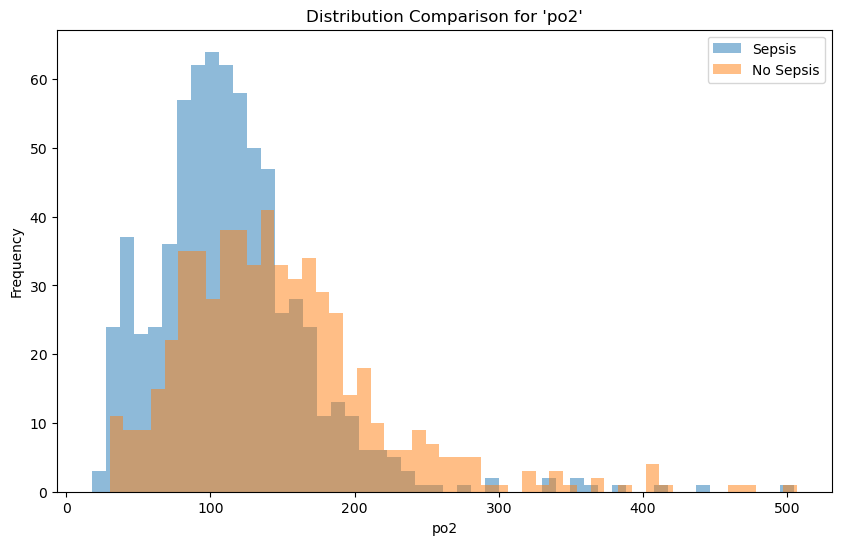

In [19]:
compare_distributions(sepsis_data, no_sepsis_data, 'po2', "Sepsis", "No Sepsis")

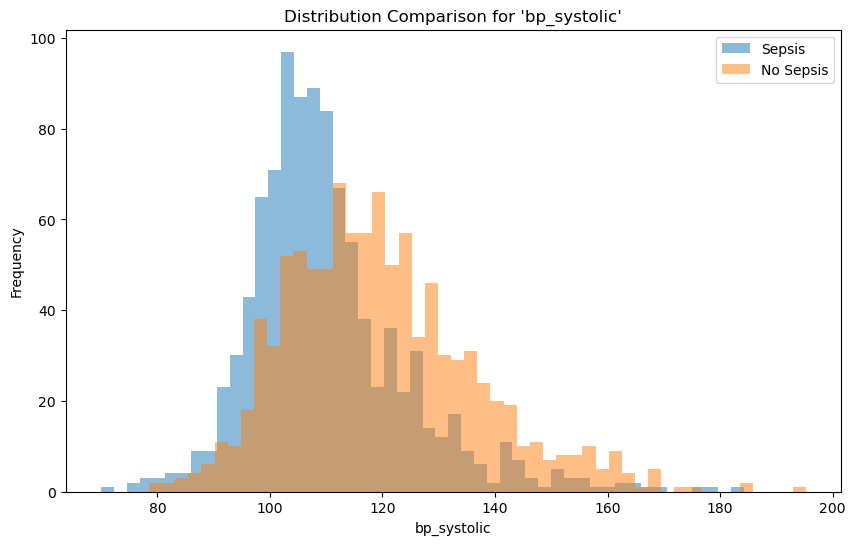

In [20]:
compare_distributions(sepsis_data, no_sepsis_data, 'bp_systolic', "Sepsis", "No Sepsis")

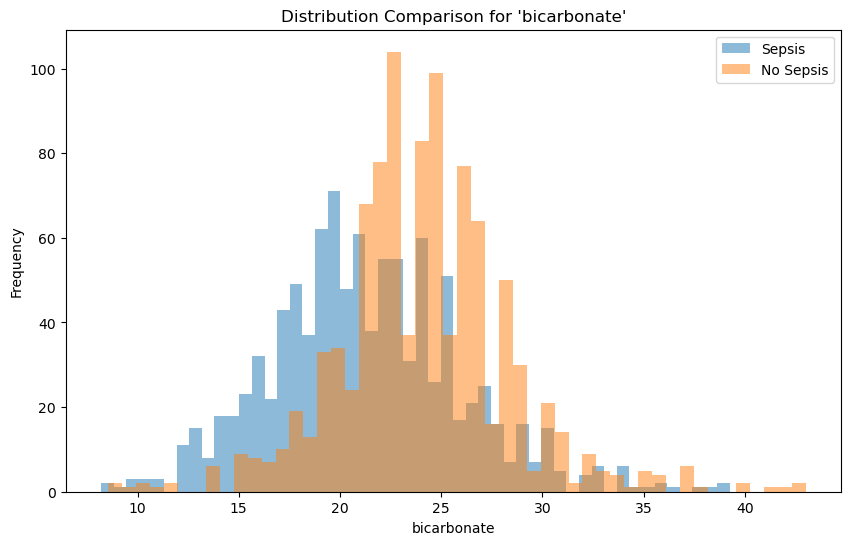

In [21]:
compare_distributions(sepsis_data, no_sepsis_data, 'bicarbonate', "Sepsis", "No Sepsis")

## Data Preprocessing

In [23]:
# Selecting the chosen features
selected_features = [
    'bp_systolic', 'resp','bun',
    'heart_rate','bicarbonate'
]

# Handle missing values by imputing with median values
for feature in selected_features:
    median_value = selected_combined_data[feature].median()
    selected_combined_data[feature] = selected_combined_data[feature].fillna(median_value)

# Features (X) and target (y)
X = selected_combined_data[selected_features]
y = selected_combined_data['sepsis_icd']

# Calculating descriptive statistics
stats = combined_data[selected_features].agg(["min", "max", "mean", "median", "std"]).transpose()
stats.columns = ["Min", "Max", "Mean", "Median", "Std Dev"]

# Calculate the Min-Max Range
stats["Min-Max Range"] = stats["Max"] - stats["Min"]

# Display the statistics
print(stats)

                   Min         Max        Mean      Median    Std Dev  \
bp_systolic  70.000000  195.208333  114.920780  112.151515  16.326004   
resp          9.250000   42.333333   19.987511   19.395652   4.507643   
bun           2.666667  217.000000   29.652348   22.000000  23.350275   
heart_rate   43.739130  151.250000   88.026142   87.041667  16.418328   
bicarbonate   8.200000   43.000000   22.702593   22.952381   4.718251   

             Min-Max Range  
bp_systolic     125.208333  
resp             33.083333  
bun             214.333333  
heart_rate      107.510870  
bicarbonate      34.800000  


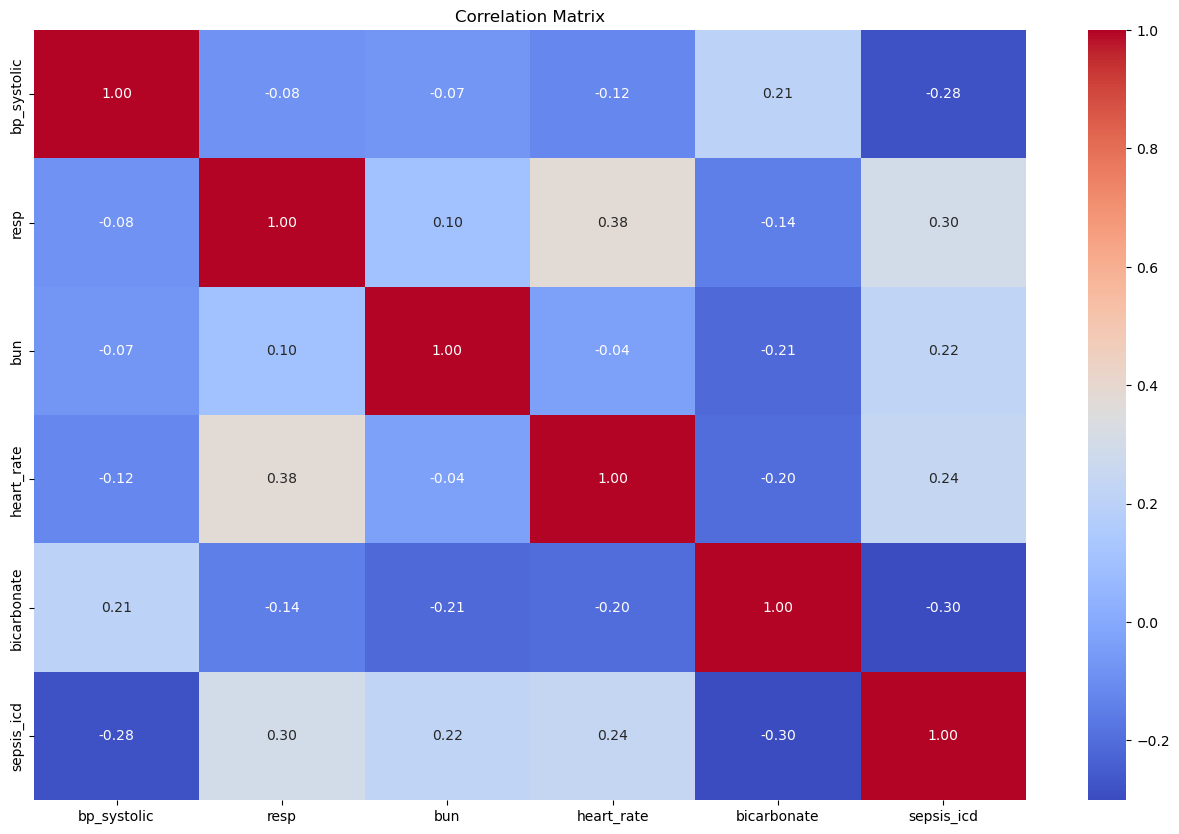

Correlations with sepsis_icd (sorted):
sepsis_icd     1.000000
resp           0.296684
heart_rate     0.242056
bun            0.219593
bp_systolic   -0.284987
bicarbonate   -0.301249
Name: sepsis_icd, dtype: float64


In [24]:
plot_correlation_matrix(combined_data[selected_features + ['sepsis_icd']],'sepsis_icd')

## Fuzzy Variables

In [26]:
bicarbonate_step = 0.1
bun_step = 1.0
heart_rate_step = 1.0
resp_step = 0.1
bp_systolic_step = 1.0

bicarbonate = ctrl.Antecedent(np.arange(stats.loc['bicarbonate', 'Min'], stats.loc['bicarbonate', 'Max'] + bicarbonate_step, bicarbonate_step), 'bicarbonate')
bun = ctrl.Antecedent(np.arange(stats.loc['bun', 'Min'], stats.loc['bun', 'Max'] + bun_step, bun_step), 'bun')
heart_rate = ctrl.Antecedent(np.arange(stats.loc['heart_rate', 'Min'], stats.loc['heart_rate', 'Max'] + heart_rate_step, heart_rate_step), 'heart_rate')
resp = ctrl.Antecedent(np.arange(stats.loc['resp', 'Min'], stats.loc['resp', 'Max'] + resp_step, resp_step), 'resp')
bp_systolic = ctrl.Antecedent(np.arange(stats.loc['bp_systolic', 'Min'], stats.loc['bp_systolic', 'Max'] + bp_systolic_step, bp_systolic_step), 'bp_systolic')

# Define the Consequent variable with a suitable step
sepsis_risk = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'sepsis_risk')

## Membership Functions

In [28]:
# For bicarbonate
bicarbonate['low'] = fuzz.trimf(bicarbonate.universe, [stats.loc['bicarbonate', 'Min'], stats.loc['bicarbonate', 'Min'], stats.loc['bicarbonate', 'Median']])
bicarbonate['normal'] = fuzz.trimf(bicarbonate.universe, [stats.loc['bicarbonate', 'Min'], stats.loc['bicarbonate', 'Median'], stats.loc['bicarbonate', 'Max']])
bicarbonate['high'] = fuzz.trimf(bicarbonate.universe, [stats.loc['bicarbonate', 'Median'], stats.loc['bicarbonate', 'Max'], stats.loc['bicarbonate', 'Max']])

# For bun (Blood Urea Nitrogen)
bun['low'] = fuzz.trimf(bun.universe, [stats.loc['bun', 'Min'], stats.loc['bun', 'Min'], stats.loc['bun', 'Median']])
bun['normal'] = fuzz.trimf(bun.universe, [stats.loc['bun', 'Min'], stats.loc['bun', 'Median'], stats.loc['bun', 'Max']])
bun['high'] = fuzz.trimf(bun.universe, [stats.loc['bun', 'Median'], stats.loc['bun', 'Max'], stats.loc['bun', 'Max']])

# For heart_rate
heart_rate['low'] = fuzz.trimf(heart_rate.universe, [stats.loc['heart_rate', 'Min'], stats.loc['heart_rate', 'Min'], stats.loc['heart_rate', 'Median']])
heart_rate['normal'] = fuzz.trimf(heart_rate.universe, [stats.loc['heart_rate', 'Min'], stats.loc['heart_rate', 'Median'], stats.loc['heart_rate', 'Max']])
heart_rate['high'] = fuzz.trimf(heart_rate.universe, [stats.loc['heart_rate', 'Median'], stats.loc['heart_rate', 'Max'], stats.loc['heart_rate', 'Max']])

# For resp
resp['low'] = fuzz.trimf(resp.universe, [stats.loc['resp', 'Min'], stats.loc['resp', 'Min'], stats.loc['resp', 'Median']])
resp['normal'] = fuzz.trimf(resp.universe, [stats.loc['resp', 'Min'], stats.loc['resp', 'Median'], stats.loc['resp', 'Max']])
resp['high'] = fuzz.trimf(resp.universe, [stats.loc['resp', 'Median'], stats.loc['resp', 'Max'], stats.loc['resp', 'Max']])

# For bp_systolic
bp_systolic['low'] = fuzz.trimf(bp_systolic.universe, [stats.loc['bp_systolic', 'Min'], stats.loc['bp_systolic', 'Min'], stats.loc['bp_systolic', 'Median']])
bp_systolic['normal'] = fuzz.trimf(bp_systolic.universe, [stats.loc['bp_systolic', 'Min'], stats.loc['bp_systolic', 'Median'], stats.loc['bp_systolic', 'Max']])
bp_systolic['high'] = fuzz.trimf(bp_systolic.universe, [stats.loc['bp_systolic', 'Median'], stats.loc['bp_systolic', 'Max'], stats.loc['bp_systolic', 'Max']])

# For sepsis_risk
sepsis_risk['low'] = fuzz.trimf(sepsis_risk.universe, [0, 0, 0.5])
sepsis_risk['high'] = fuzz.trimf(sepsis_risk.universe, [0.5, 1, 1])

C:\Users\stajyer\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


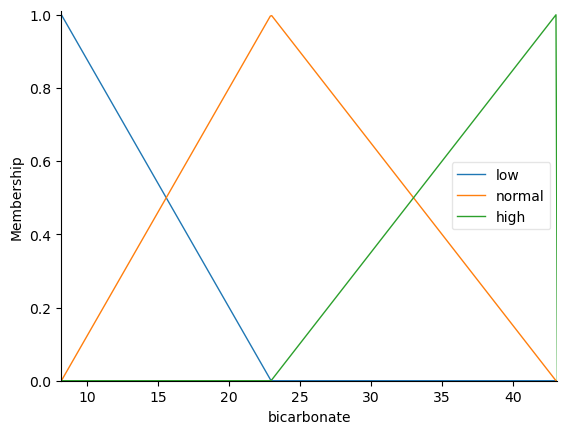

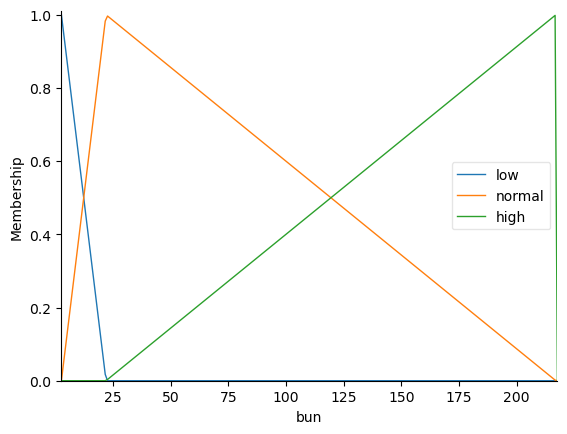

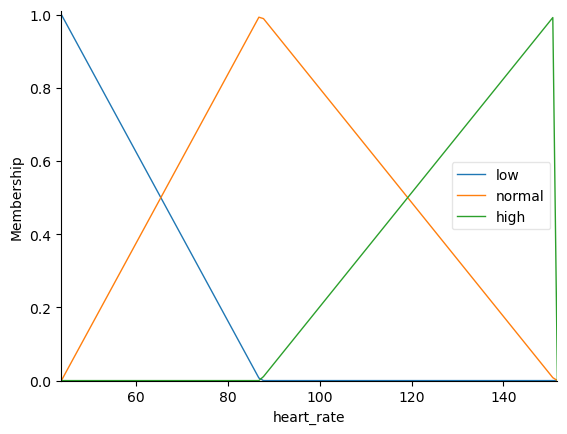

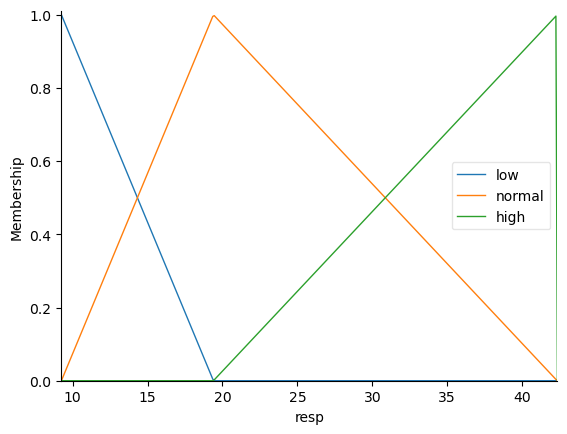

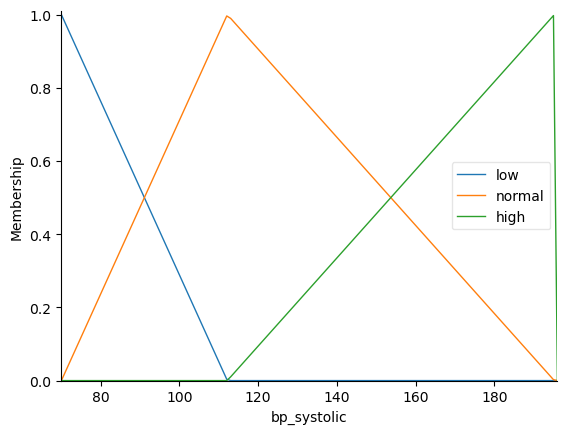

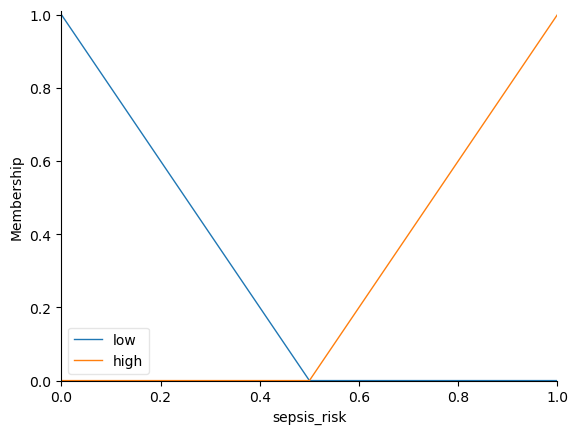

In [29]:
%matplotlib inline
bicarbonate.view()
bun.view()
heart_rate.view()
resp.view()
bp_systolic.view()
sepsis_risk.view()


## Rule Base

In [31]:
rule1 = ctrl.Rule(bicarbonate['normal'] & bun['low'] & heart_rate['normal'] & resp['normal'] & bp_systolic['normal'], sepsis_risk['low'])

rule2 = ctrl.Rule(bicarbonate['normal'] & bun['normal'] & heart_rate['low'] & resp['normal'] & bp_systolic['normal'], sepsis_risk['low'])

rule3 = ctrl.Rule(bicarbonate['high'] & bun['normal'] & heart_rate['normal'] & resp['normal'] & bp_systolic['normal'], sepsis_risk['low'])

rule4 = ctrl.Rule(bicarbonate['normal'] & bun['normal'] & heart_rate['normal'] & resp['low'] & bp_systolic['high'], sepsis_risk['low'])

rule5 = ctrl.Rule(bicarbonate['low'] & bun['normal'] & heart_rate['normal'] & resp['normal'] & bp_systolic['normal'], sepsis_risk['high'])

rule6 = ctrl.Rule(bicarbonate['normal'] & bun['normal'] & heart_rate['normal'] & resp['normal'] & bp_systolic['low'], sepsis_risk['high'])

rule7 = ctrl.Rule(bicarbonate['normal'] & bun['normal'] & heart_rate['normal'] & resp['high'] & bp_systolic['normal'], sepsis_risk['high'])


In [32]:
# Create the control system
sepsis_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])

# Create a simulation instance
sepsis_simulation = ctrl.ControlSystemSimulation(sepsis_ctrl)

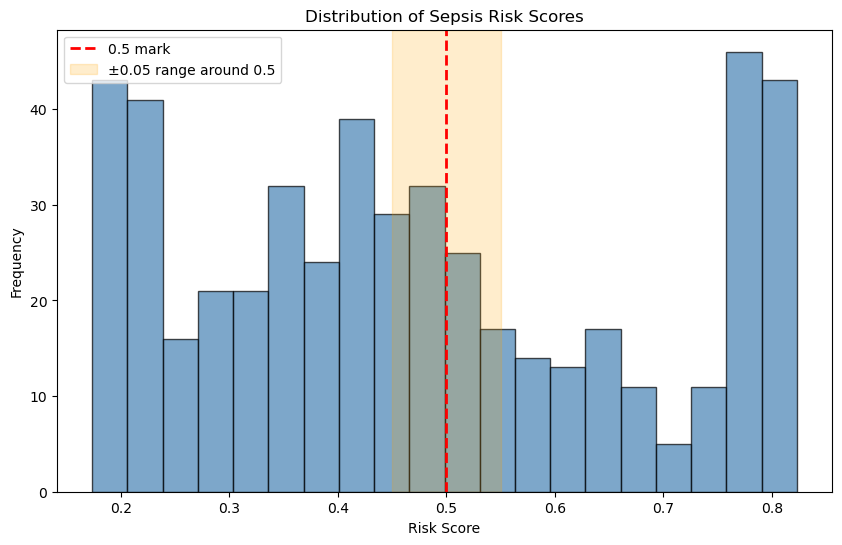

Percentage of risk scores that are close to 0.5 16.6%


In [33]:
# Initialize lists to store predictions and actual values
predictions = []
actual_values = y.tolist()
risk_scores = []

# Define a threshold for classifying sepsis risk
threshold = 0.40 # You can adjust this threshold based on your needs

# Iterate over the test samples
for index, row in X.iterrows():
    # Reset the simulation
    sepsis_simulation.reset()
    
    # Input the values into the simulation
    for feature in selected_features:
        min_val = stats.loc[feature, 'Min']
        max_val = stats.loc[feature, 'Max']
        value = np.clip(row[feature], min_val, max_val)
        sepsis_simulation.input[feature] = value
    
    # Compute the result
    try:
        sepsis_simulation.compute()
        # Get the output sepsis risk
        risk = sepsis_simulation.output['sepsis_risk']
    except Exception as e:
        print(row)
        print(f"Error processing index {index}: {e}")
        risk = 0  # Assign default risk in case of error
    risk_scores.append(risk)
    # Classify based on the threshold
    prediction = 1 if risk >= threshold else 0
    predictions.append(prediction)
    
around_0_5_tolerance = 0.05
percent_threshold = 0.5  # 50%

close_to_half = [score for score in risk_scores if 0.5 - around_0_5_tolerance <= score <= 0.5 + around_0_5_tolerance]
ratio_close_to_half = len(close_to_half) / len(risk_scores)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram of risk scores
n, bins, patches = plt.hist(risk_scores, bins=20, color='steelblue', edgecolor='black', alpha=0.7)

plt.title('Distribution of Sepsis Risk Scores')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')

# Highlight the region around 0.5
around_0_5_tolerance = 0.05
lower_bound = 0.5 - around_0_5_tolerance
upper_bound = 0.5 + around_0_5_tolerance

plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='0.5 mark')
plt.axvspan(lower_bound, upper_bound, color='orange', alpha=0.2, label='±0.05 range around 0.5')

plt.legend()
plt.show()

print (f"Percentage of risk scores that are close to 0.5 {ratio_close_to_half*100}%")

## Results

[[152  98]
 [ 45 205]]


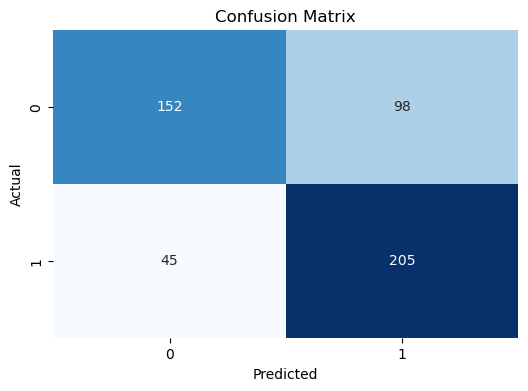

In [35]:
# Confusion Matrix
cm = confusion_matrix(actual_values, predictions)
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [36]:
tn, fp, fn, tp = cm.ravel()
tpr = tp / (tp + fn)  # True Positive Rate
fpr = fp / (fp + tn)  # False Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fnr = fn / (tp + fn)  # False Negative Rate
print(f"TPR (Recall): {tpr:.2f}, FPR: {fpr:.2f}, TNR: {tnr:.2f}, FNR: {fnr:.2f}")

TPR (Recall): 0.82, FPR: 0.39, TNR: 0.61, FNR: 0.18


In [37]:
accuracy = accuracy_score(actual_values, predictions)
precision = precision_score(actual_values, predictions)
recall = recall_score(actual_values, predictions)
f1 = f1_score(actual_values, predictions)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.7140
Precision: 0.6766
Recall (Sensitivity): 0.8200
F1-Score: 0.7414


In [38]:
# Classification Report
print("\nClassification Report:")
print(classification_report(actual_values, predictions, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.7716    0.6080    0.6801       250
           1     0.6766    0.8200    0.7414       250

    accuracy                         0.7140       500
   macro avg     0.7241    0.7140    0.7107       500
weighted avg     0.7241    0.7140    0.7107       500



In [39]:
# Compute ROC AUC
roc_auc = roc_auc_score(actual_values, predictions)
print(f"\nROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.7140


Optimal Threshold: 0.40239033896360876


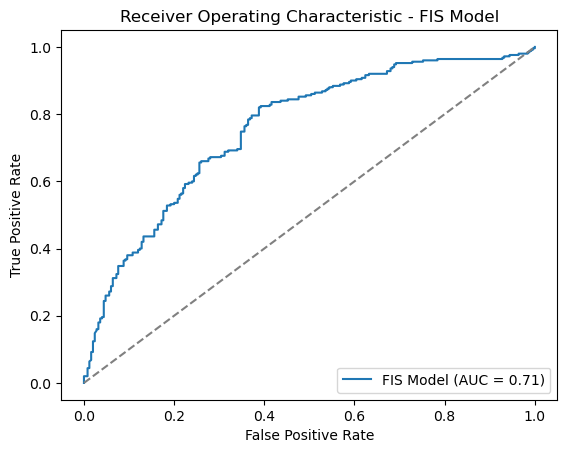

In [40]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(actual_values, risk_scores)

# Compute Youden's Index
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'FIS Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - FIS Model')
plt.legend(loc='lower right')
plt.show()